In [1]:
### SETUP ###
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
from SCRIPTS.config import *
from SCRIPTS.dataprep import prepare_data
from SCRIPTS.models import AttentionFullModel, BrainStateFullModel
from SCRIPTS.train import train_autoencoder, train_attention_model
from SCRIPTS.cross_validation_experiments import (
    run_autoencoder_cross_validation,
    run_attention_cross_validation
)
from SCRIPTS.attention_visualization import plot_attention_weights_with_regions

# Visualization setup
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Data path: {COMBINED_SCATTERING}")
print(f"Results path: {CROSS_VALIDATION_RESULTS_DIR}")

Using device: cpu
Data path: /Users/judesack/Neurospectrum_Creativity/DATA/SCATTERING_COEFFICIENTS/combined_scattering_data.csv
Results path: /Users/judesack/Neurospectrum_Creativity/RESULTS/cross_validation_results


In [14]:
### CONFIGURATION ###

# Train autoencoder models? T/F
TRAIN_AUTOENCODER = False

# Train attention models? T/F  
TRAIN_ATTENTION = True

# Run cross-validation? T/F
RUN_CROSS_VALIDATION = True

# Number of CV trials (set to 5)
CV_TRIALS = 5

# Latent dimensions to test
LATENT_DIMS = [8, 48]

# Visualize attention weights by brain region? T/F
VISUALIZE_ATTENTION_REGIONS = True

# Path to brain regions CSV
BRAIN_REGIONS_CSV = POS_DATA_DIR / "xyz_primary_regions_snapped.csv"


In [3]:
### AUTOENCODER MODELS ###

if TRAIN_AUTOENCODER:
    print("\n=== TRAINING AUTOENCODER MODELS ===")
    results = {}
    
    for latent_dim in LATENT_DIMS:
        print(f"\n--- Latent Dimension: {latent_dim} ---")
        latent_results = {}

        print("\nSUBJECT WITHHOLDING:")
        train_loader, test_loader = prepare_data(
            data_path=COMBINED_SCATTERING,
            feature_prefix="feature_",
            include_metadata=True,
            split_type="subject"
        )
        
        model, history = train_autoencoder(
            train_loader=train_loader,
            test_loader=test_loader,
            num_epochs=DEFAULT_EPOCHS,
            latent_dim=latent_dim,
            split_name=f"Subject-{latent_dim}D"
        )
        
        save_path = BASELINE_RESULTS_DIR / f'autoencoder_subject_{latent_dim}d.pth'
        torch.save({
            'model_state_dict': model.state_dict(),
            'history': history,
            'split_type': 'subject',
            'latent_dim': latent_dim
        }, save_path)
        
        latent_results['subject'] = {
            'accuracy': history['test_accuracy'],
        }
        
        print("\nTIME WITHHOLDING:")
        train_loader, test_loader = prepare_data(
            data_path=COMBINED_SCATTERING,
            feature_prefix="feature_",
            include_metadata=True,
            split_type="time"
        )
        
        model, history = train_autoencoder(
            train_loader=train_loader,
            test_loader=test_loader,
            num_epochs=DEFAULT_EPOCHS,
            latent_dim=latent_dim,
            split_name=f"Time-{latent_dim}D"
        )
        
        save_path = BASELINE_RESULTS_DIR / f'autoencoder_time_{latent_dim}d.pth'
        torch.save({
            'model_state_dict': model.state_dict(),
            'history': history,
            'split_type': 'time',
            'latent_dim': latent_dim
        }, save_path)
        
        latent_results['time'] = {
            'accuracy': history['test_accuracy'],
        }
        results[latent_dim] = latent_results
    
    print("\n=== AUTOENCODER RESULTS SUMMARY ===")
    for latent_dim in LATENT_DIMS:
        print(f"\nLatent Dimension: {latent_dim}")
        print(f"  Subject-withheld: {results[latent_dim]['subject']['accuracy']:.2f}%")
        print(f"  Time-withheld: {results[latent_dim]['time']['accuracy']:.2f}%")

else:
    print("✓ Skipping autoencoder training")

✓ Skipping autoencoder training


In [15]:
### ATTENTION MODELS ###

if TRAIN_ATTENTION:
    print("\n=== TRAINING ATTENTION MODELS ===")
    
    print("\nSUBJECT WITHHOLDING:")
    train_loader, test_loader = prepare_data(
        data_path=COMBINED_SCATTERING,
        feature_prefix="feature_",
        include_metadata=True,
        split_type="subject"
    )
    
    subject_model, subject_history = train_attention_model(
        train_loader=train_loader,
        test_loader=test_loader,
        num_epochs=DEFAULT_EPOCHS,
        latent_dim=48,
        split_name="Subject"
    )
    
    save_path = ATTENTION_RESULTS_DIR / 'attention_subject.pth'
    torch.save({
        'model_state_dict': subject_model.state_dict(),
        'history': subject_history,
        'split_type': 'subject'
    }, save_path)
    print(f"✓ Model saved to {save_path}")
    
    print("\nTIME WITHHOLDING:")
    train_loader, test_loader = prepare_data(
        data_path=COMBINED_SCATTERING,
        feature_prefix="feature_",
        include_metadata=True,
        split_type="time"
    )
    
    time_model, time_history = train_attention_model(
        train_loader=train_loader,
        test_loader=test_loader,
        num_epochs=DEFAULT_EPOCHS,
        latent_dim=48,
        split_name="Time"
    )
    
    save_path = ATTENTION_RESULTS_DIR / 'attention_time.pth'
    torch.save({
        'model_state_dict': time_model.state_dict(),
        'history': time_history,
        'split_type': 'time'
    }, save_path)
    print(f"✓ Model saved to {save_path}")
    
    print("\n=== ATTENTION MODEL RESULTS ===")
    print(f"Subject-withheld: {subject_history['test_accuracy']:.2f}%")
    print(f"Time-withheld: {time_history['test_accuracy']:.2f}%")

else:
    print("✓ Skipping attention model training")



=== TRAINING ATTENTION MODELS ===

SUBJECT WITHHOLDING:

Split: subject — train 100800, test 21600
Subject Epoch 10/100 - Loss: 0.3458 (R: 0.1309, C: 0.2149), Acc: 91.78%
Subject Epoch 20/100 - Loss: 0.2548 (R: 0.1079, C: 0.1469), Acc: 94.54%
Subject Epoch 30/100 - Loss: 0.2196 (R: 0.1001, C: 0.1195), Acc: 95.66%
Subject Epoch 40/100 - Loss: 0.2004 (R: 0.0969, C: 0.1036), Acc: 96.29%
Subject Epoch 50/100 - Loss: 0.1910 (R: 0.0962, C: 0.0948), Acc: 96.66%
Subject Epoch 60/100 - Loss: 0.1813 (R: 0.0950, C: 0.0863), Acc: 96.96%
Subject Epoch 70/100 - Loss: 0.1798 (R: 0.0942, C: 0.0856), Acc: 97.01%
Subject Epoch 80/100 - Loss: 0.1718 (R: 0.0924, C: 0.0794), Acc: 97.27%
Subject Epoch 90/100 - Loss: 0.1710 (R: 0.0947, C: 0.0762), Acc: 97.35%
Subject Epoch 100/100 - Loss: 0.1706 (R: 0.0955, C: 0.0750), Acc: 97.41%
Subject Test Accuracy: 51.74%
✓ Model saved to /Users/judesack/Neurospectrum_Creativity/RESULTS/attention_results/attention_subject.pth

TIME WITHHOLDING:

Split: time — train 979

In [5]:
### CROSS-VALIDATION ###

if RUN_CROSS_VALIDATION:
    print(f"\n=== CROSS-VALIDATION EXPERIMENTS ({CV_TRIALS} trials) ===")
    
    cv_results = {'autoencoder': {}, 'attention': {}}
    
    for latent_dim in LATENT_DIMS:
        print(f"\n--- LATENT DIMENSION: {latent_dim} ---")
        
        print("\nAUTOENCODER CROSS-VALIDATION:")
        ae_results = {}
        
        for split_type in ["subject", "time"]:
            print(f"  {split_type} split:")
            ae_results[split_type] = run_autoencoder_cross_validation(
                data_path=COMBINED_SCATTERING,
                feature_prefix="feature_",
                split_type=split_type,
                latent_dim=latent_dim,
                num_trials=CV_TRIALS,
                num_epochs=DEFAULT_EPOCHS
            )
        
        cv_results['autoencoder'][latent_dim] = ae_results
        
        print("\nATTENTION MODEL CROSS-VALIDATION:")
        attn_results = {}
        
        for split_type in ["subject", "time"]:
            print(f"  {split_type} split:")
            attn_results[split_type] = run_attention_cross_validation(
                data_path=COMBINED_SCATTERING,
                feature_prefix="feature_",
                split_type=split_type,
                latent_dim=latent_dim,
                num_trials=CV_TRIALS,
                num_epochs=DEFAULT_EPOCHS
            )
        
        cv_results['attention'][latent_dim] = attn_results
    
    # Save results
    save_path = CROSS_VALIDATION_RESULTS_DIR / 'thesis_model_cv_results.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump(cv_results, f)
    print(f"\n✓ Results saved to {save_path}")
    
    print("\n=== CROSS-VALIDATION SUMMARY ===")
    for latent_dim in LATENT_DIMS:
        print(f"\n--- {latent_dim}D Latent Space ---")
        
        if latent_dim in cv_results['autoencoder']:
            ae_res = cv_results['autoencoder'][latent_dim]
            print("Autoencoder:")
            print(f"  Subject: {ae_res['subject']['mean_accuracy']:.2%} ± {ae_res['subject']['std_accuracy']:.2%}")
            print(f"  Time: {ae_res['time']['mean_accuracy']:.2%} ± {ae_res['time']['std_accuracy']:.2%}")
        
        if latent_dim in cv_results['attention']:
            attn_res = cv_results['attention'][latent_dim]
            print("Attention Model:")
            print(f"  Subject: {attn_res['subject']['mean_accuracy']:.2%} ± {attn_res['subject']['std_accuracy']:.2%}")
            print(f"  Time: {attn_res['time']['mean_accuracy']:.2%} ± {attn_res['time']['std_accuracy']:.2%}")

else:
    # Load existing results
    cv_file = CROSS_VALIDATION_RESULTS_DIR / 'thesis_model_cv_results.pkl'
    
    if cv_file.exists():
        with open(cv_file, 'rb') as f:
            cv_results = pickle.load(f)
        
        print("✓ Loaded existing cross-validation results")
        
        print("\n=== CROSS-VALIDATION SUMMARY ===")
        for latent_dim in LATENT_DIMS:
            print(f"\n--- {latent_dim}D Latent Space ---")
            
            if 'autoencoder' in cv_results and latent_dim in cv_results['autoencoder']:
                ae_res = cv_results['autoencoder'][latent_dim]
                print("Autoencoder:")
                print(f"  Subject: {ae_res['subject']['mean_accuracy']:.2%} ± {ae_res['subject']['std_accuracy']:.2%}")
                print(f"  Time: {ae_res['time']['mean_accuracy']:.2%} ± {ae_res['time']['std_accuracy']:.2%}")
            
            if 'attention' in cv_results and latent_dim in cv_results['attention']:
                attn_res = cv_results['attention'][latent_dim]
                print("Attention Model:")
                print(f"  Subject: {attn_res['subject']['mean_accuracy']:.2%} ± {attn_res['subject']['std_accuracy']:.2%}")
                print(f"  Time: {attn_res['time']['mean_accuracy']:.2%} ± {attn_res['time']['std_accuracy']:.2%}")
    else:
        print("✓ No existing cross-validation results found")


=== CROSS-VALIDATION EXPERIMENTS (5 trials) ===

--- LATENT DIMENSION: 8 ---

AUTOENCODER CROSS-VALIDATION:
  subject split:

=== Autoencoder Trial 1/5 (subject split, 8D) ===

Split: subject — train 100800, test 21600
Using cpu device with latent dimension 8
CV1-subject Epoch 10/100: Loss=0.3915 (R=0.1426, C=0.2489), Acc=90.43%
CV1-subject Epoch 20/100: Loss=0.3465 (R=0.1491, C=0.1973), Acc=92.84%
CV1-subject Epoch 30/100: Loss=0.3246 (R=0.1535, C=0.1711), Acc=93.77%
CV1-subject Epoch 40/100: Loss=0.3104 (R=0.1578, C=0.1526), Acc=94.72%
CV1-subject Epoch 50/100: Loss=0.2991 (R=0.1579, C=0.1412), Acc=95.05%
CV1-subject Epoch 60/100: Loss=0.2894 (R=0.1594, C=0.1299), Acc=95.52%
CV1-subject Epoch 70/100: Loss=0.2843 (R=0.1610, C=0.1233), Acc=95.81%
CV1-subject Epoch 80/100: Loss=0.2829 (R=0.1659, C=0.1170), Acc=96.04%
CV1-subject Epoch 90/100: Loss=0.2781 (R=0.1685, C=0.1096), Acc=96.37%
CV1-subject Epoch 100/100: Loss=0.2901 (R=0.1813, C=0.1088), Acc=96.37%
CV1-subject Test Accuracy: 5


=== VISUALIZING ATTENTION WEIGHTS BY BRAIN REGION ===

Plotting subject-withheld attention weights...


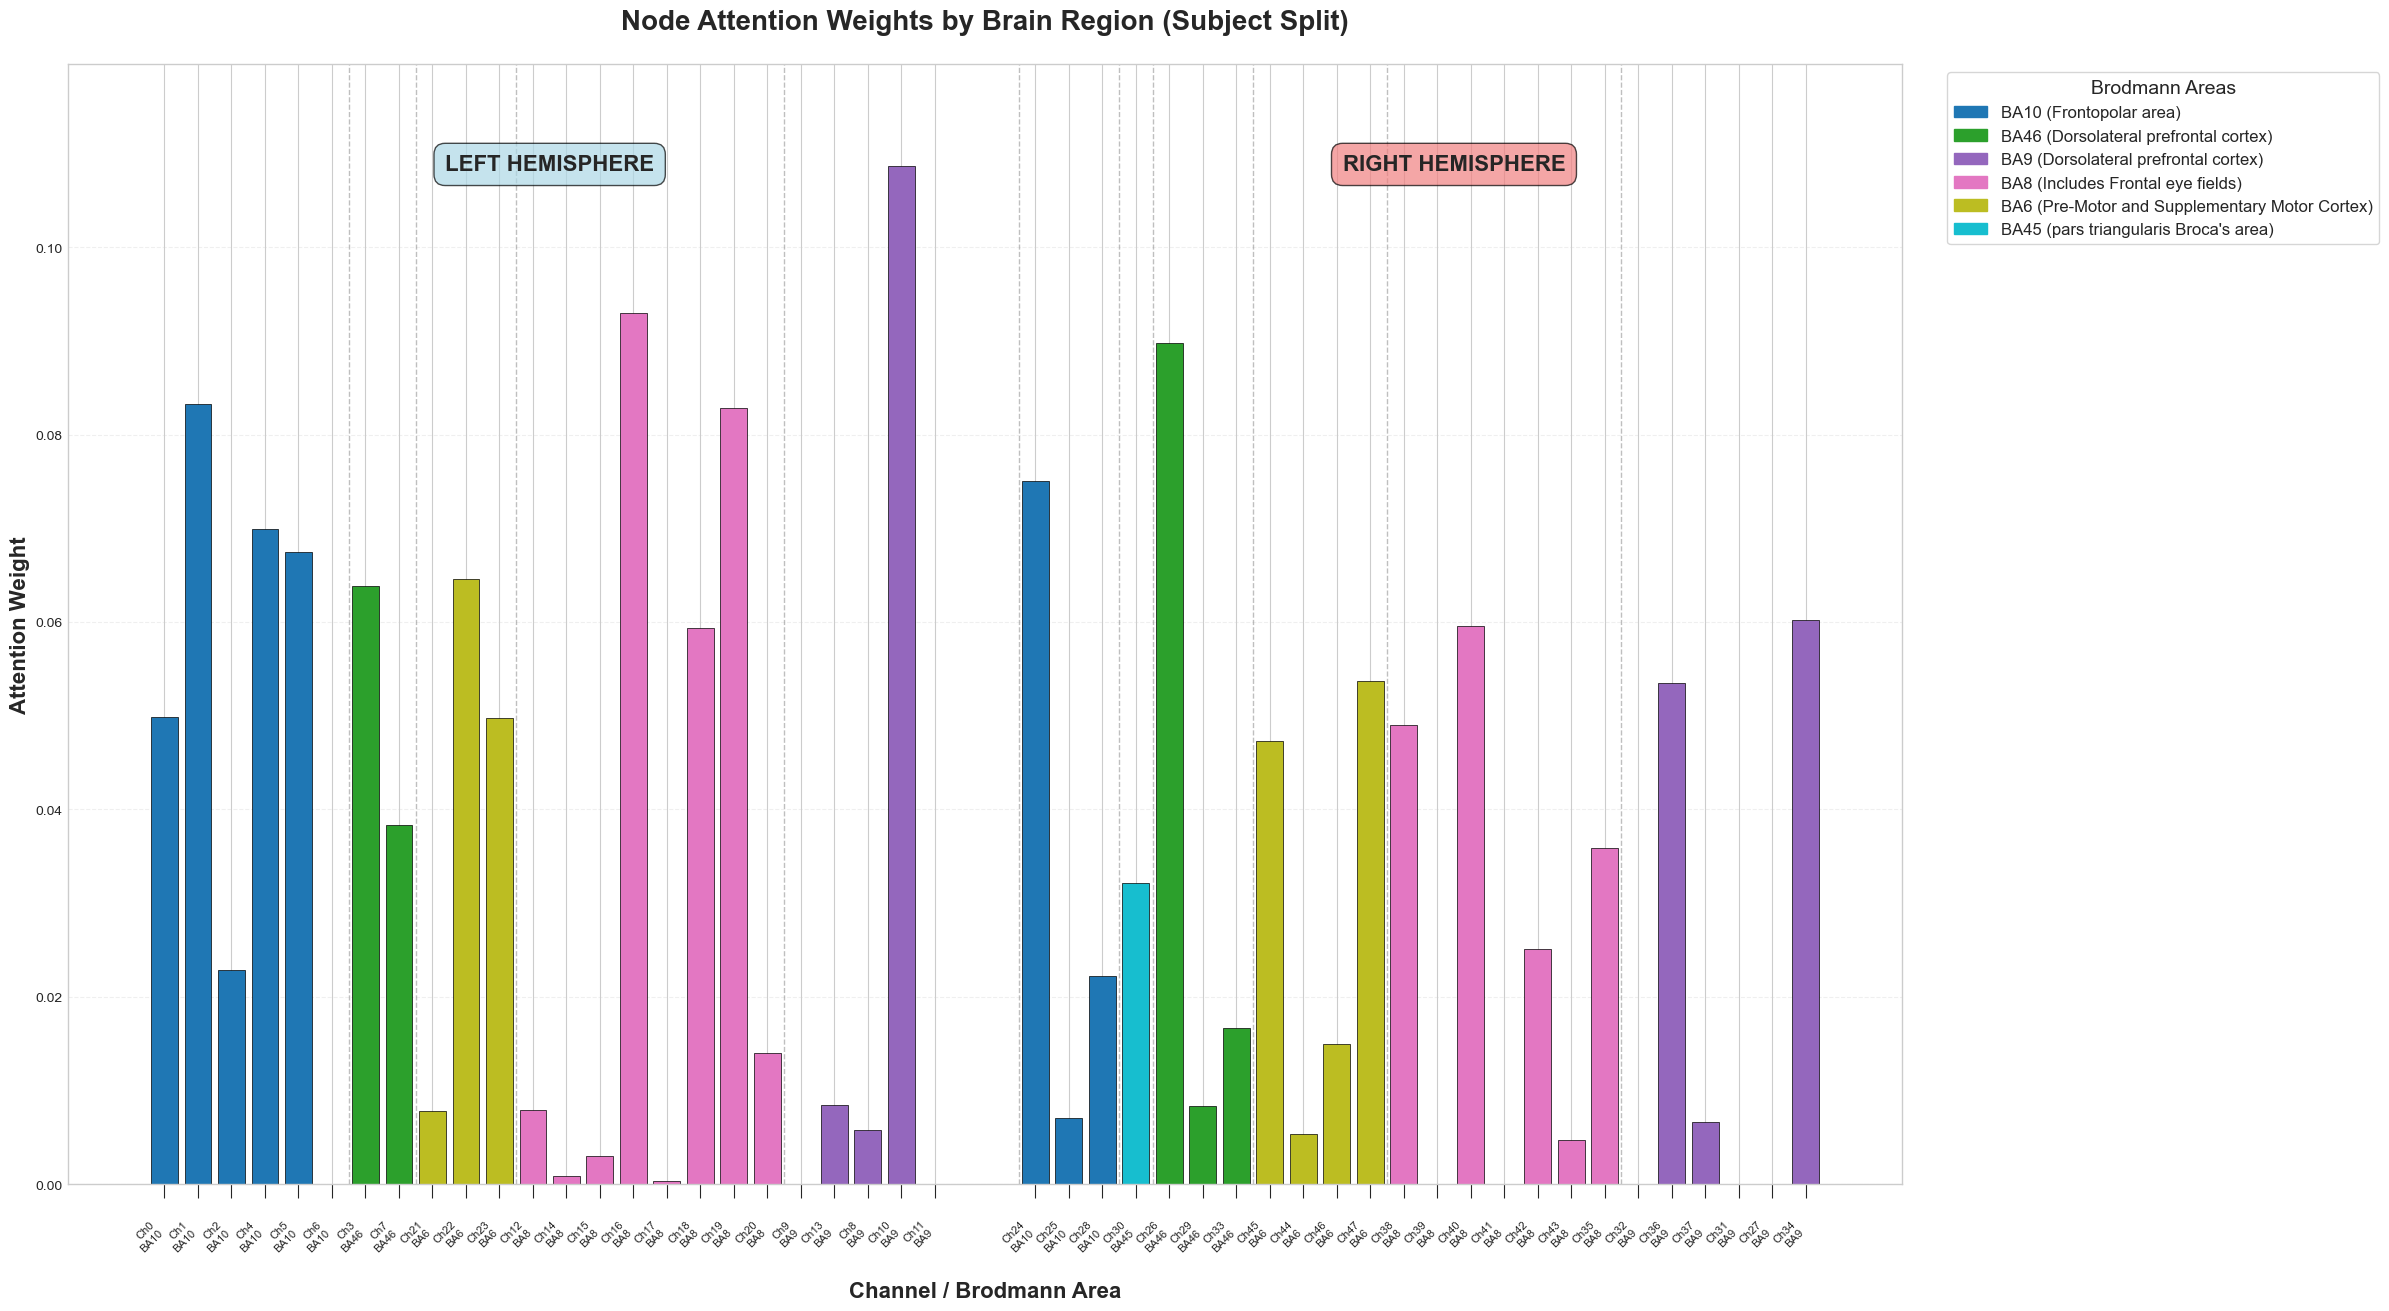


=== Attention Weight Summary by Brain Region (subject split) ===

BA10 (Frontopolar area):
  Left:  mean=0.0485, max=0.0833, n=6
  Right: mean=0.0348, max=0.0751, n=3

BA46 (Dorsolateral prefrontal cortex):
  Left:  mean=0.0511, max=0.0638, n=2
  Right: mean=0.0383, max=0.0898, n=3

BA9 (Dorsolateral prefrontal cortex):
  Left:  mean=0.0218, max=0.1087, n=5
  Right: mean=0.0184, max=0.0602, n=6

BA8 (Includes Frontal eye fields):
  Left:  mean=0.0327, max=0.0929, n=8
  Right: mean=0.0243, max=0.0596, n=7

BA6 (Pre-Motor and Supplementary Motor Cortex):
  Left:  mean=0.0407, max=0.0646, n=3
  Right: mean=0.0303, max=0.0537, n=4

BA45 (pars triangularis Broca's area):
  Right: mean=0.0322, max=0.0322, n=1

Plotting time-withheld attention weights...


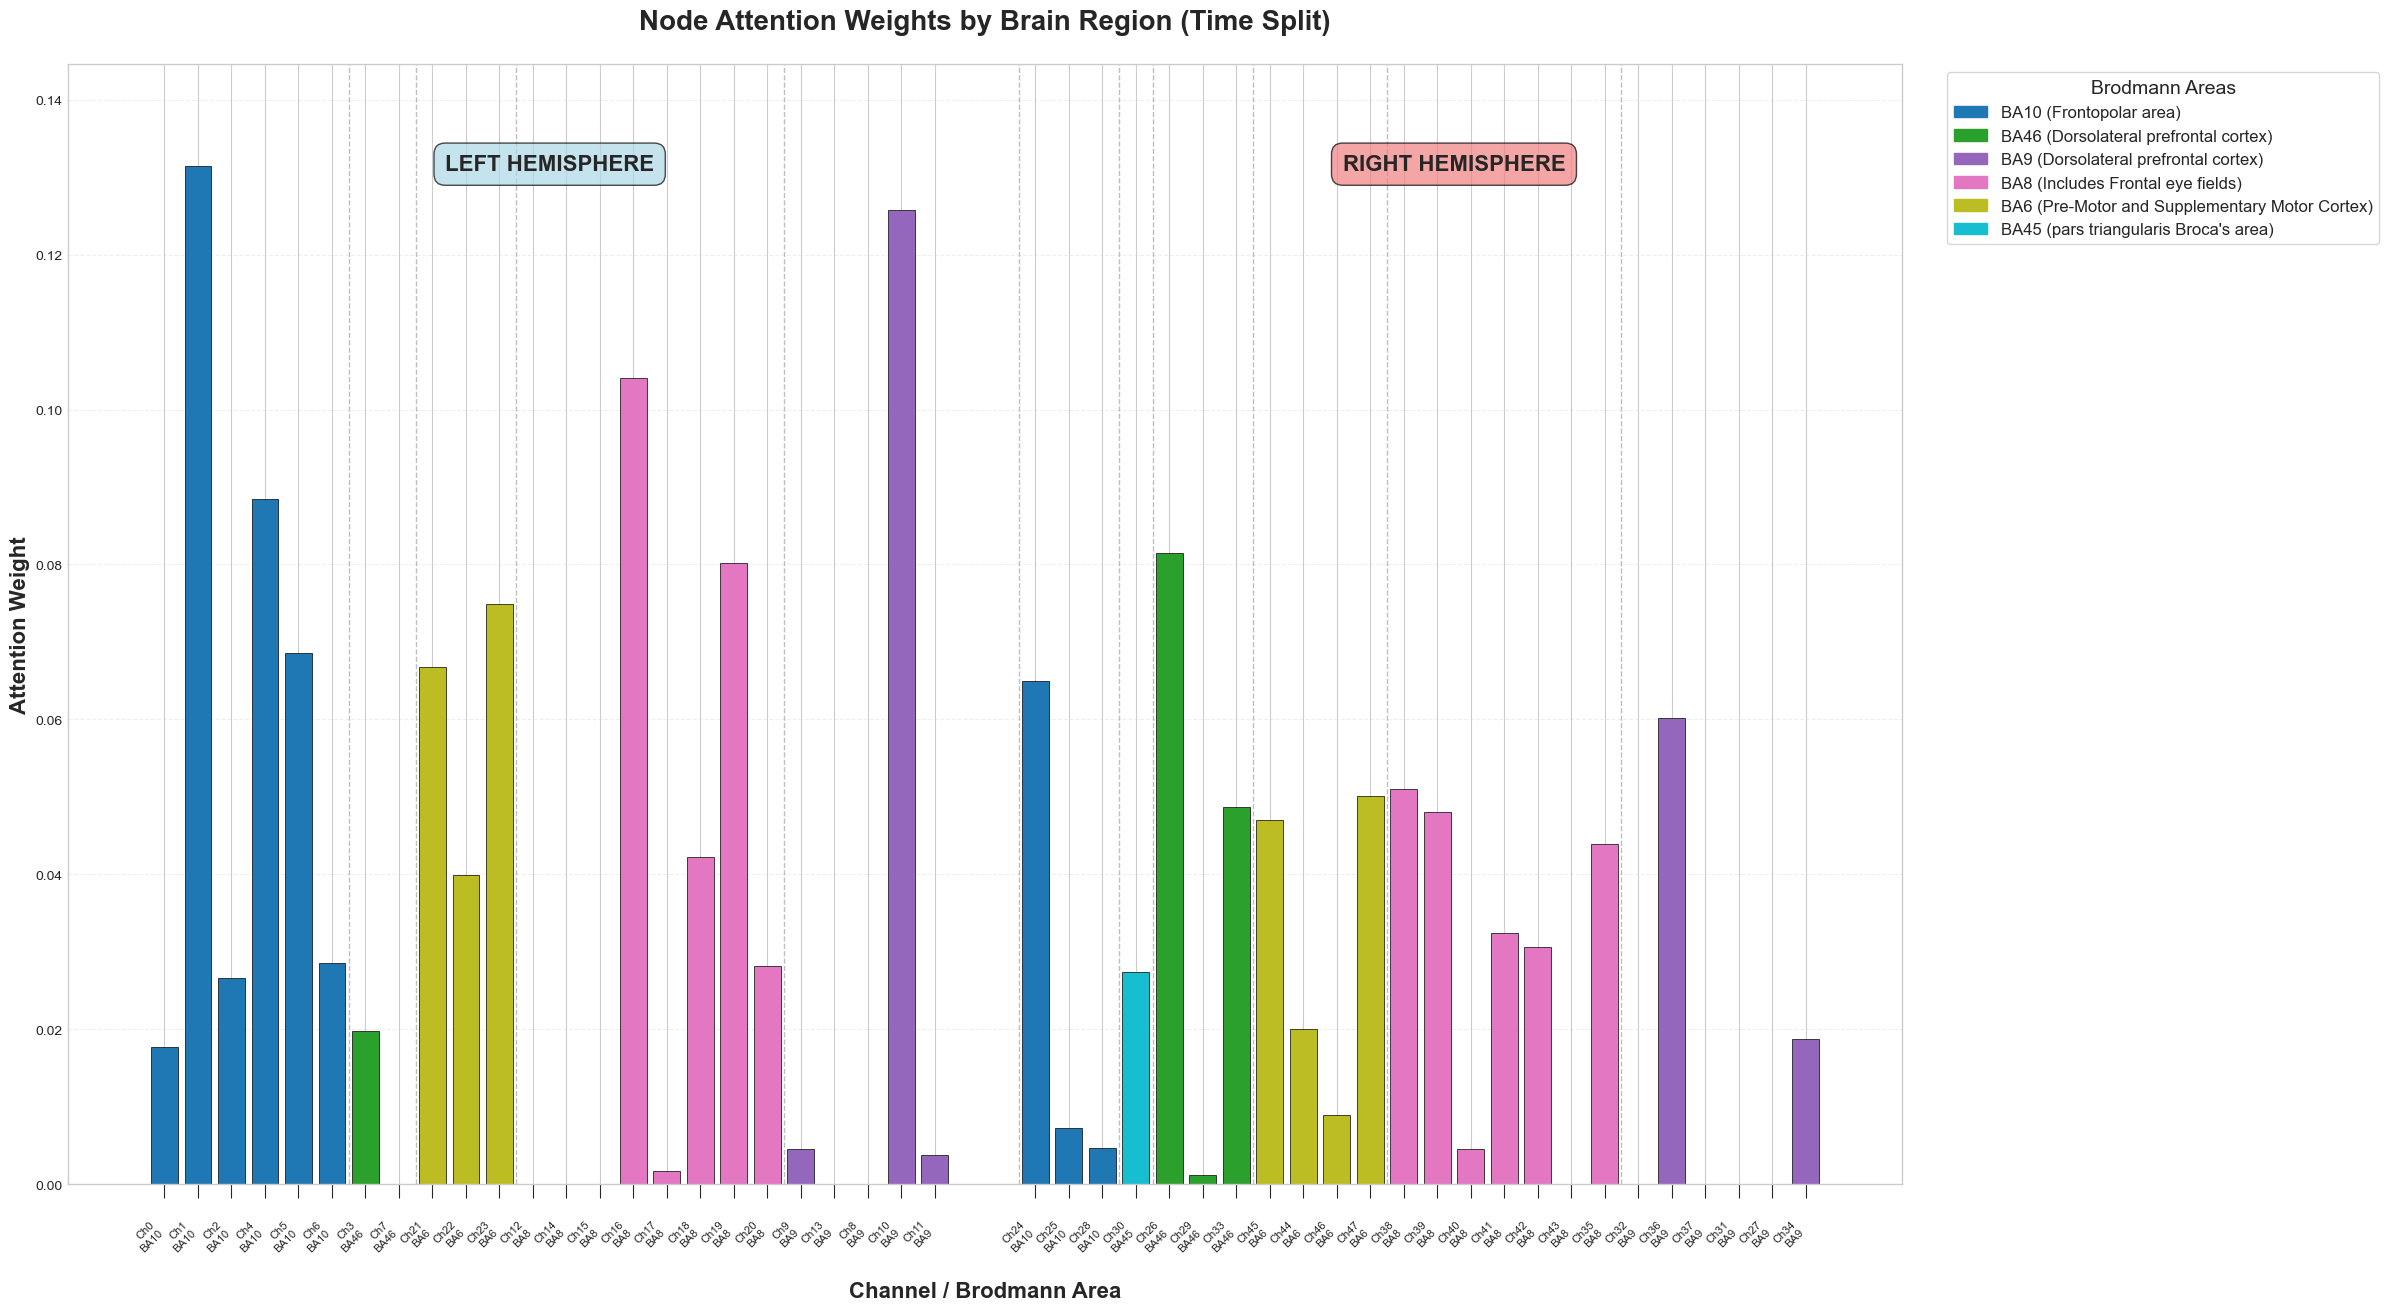


=== Attention Weight Summary by Brain Region (time split) ===

BA10 (Frontopolar area):
  Left:  mean=0.0602, max=0.1315, n=6
  Right: mean=0.0256, max=0.0650, n=3

BA46 (Dorsolateral prefrontal cortex):
  Left:  mean=0.0094, max=0.0197, n=2
  Right: mean=0.0438, max=0.0815, n=3

BA9 (Dorsolateral prefrontal cortex):
  Left:  mean=0.0254, max=0.1258, n=5
  Right: mean=0.0108, max=0.0601, n=6

BA8 (Includes Frontal eye fields):
  Left:  mean=0.0303, max=0.1040, n=8
  Right: mean=0.0298, max=0.0510, n=7

BA6 (Pre-Motor and Supplementary Motor Cortex):
  Left:  mean=0.0605, max=0.0749, n=3
  Right: mean=0.0315, max=0.0501, n=4

BA45 (pars triangularis Broca's area):
  Right: mean=0.0273, max=0.0273, n=1

✓ Correlation between subject & time attention weights: 0.7760


In [16]:
## ATTENTION VISUALIZATION BY BRAIN REGION ###

if VISUALIZE_ATTENTION_REGIONS:
    print("\n=== VISUALIZING ATTENTION WEIGHTS BY BRAIN REGION ===")
    if not BRAIN_REGIONS_CSV.exists():
        print(f"✗ Brain regions file not found at {BRAIN_REGIONS_CSV}")
    else:
        
        # Load saved attention models
        subject_path = ATTENTION_RESULTS_DIR / 'attention_subject.pth'
        time_path = ATTENTION_RESULTS_DIR / 'attention_time.pth'
        
        if subject_path.exists() and time_path.exists():
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            subject_data = torch.load(subject_path, map_location=device)
            time_data = torch.load(time_path, map_location=device)
            
            subject_weights = subject_data['history']['attention_weights'][-1]
            time_weights = time_data['history']['attention_weights'][-1]
            
            print("\nPlotting subject-withheld attention weights...")
            plot_attention_weights_with_regions(
                subject_weights, 
                str(BRAIN_REGIONS_CSV), 
                split_type="subject"
            )
            
            print("\nPlotting time-withheld attention weights...")
            plot_attention_weights_with_regions(
                time_weights, 
                str(BRAIN_REGIONS_CSV), 
                split_type="time"
            )
            
            # Compare weights
            correlation = np.corrcoef(subject_weights, time_weights)[0, 1]
            print(f"\n✓ Correlation between subject & time attention weights: {correlation:.4f}")
            
        else:
            print("✗ Attention models not found. Run with TRAIN_ATTENTION=True first")
else:
    print("✓ Skipping attention visualization")